In [1]:
# class Encoder(nn.Module):
#     def __init__(self, in_channels, hidden_channels, num_layers, heads, dropout=0.1):
#         super(Encoder, self).__init__()
#         self.num_layers = num_layers
#         self.convs = nn.ModuleList()
        
#         # 添加多层 GATConv
#         self.convs.append(GATConv(in_channels, hidden_channels, heads=heads))
#         for _ in range(num_layers - 1):
#             self.convs.append(GATConv(hidden_channels * heads, hidden_channels, heads=heads))
        
#         # 根据隐藏特征的维度设置 PReLU 参数数量
#         self.prelu = nn.PReLU(num_parameters=hidden_channels)

#         # 添加 Dropout 层
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x, edge_index):
#         # 定义一个变量用于保存输入特征，以便进行跳跃连接
#         residual = x
        
#         for conv in self.convs:
#             # 对输入特征进行图注意力操作
#             x = conv(x, edge_index)
            
#             # 将图注意力操作的结果与原始输入特征相加
#             x = x + residual

#             # 应用 Dropout 正则化
#             x = self.dropout(x)
            
#             # 应用 PReLU 激活函数
#             x = self.prelu(x)
            
#             # 更新跳跃连接的输入特征为当前层的输出
#             residual = x
        
#         return x

### Prepare data

In [2]:
import pandas as pd
import pickle
import numpy as np

In [3]:
# 读取原始数据（假设每个诊断记录为一行）
clinical_df = pd.read_csv("/home/llma/wzy/comorbidity/Data/ICD10_long.csv")

In [4]:
clinical_df.shape

(7015554, 5)

In [5]:
clinical_df.head(2)

,eid,ICD10_codes,Date,p40000_i0,p40023
0,1000122,J383,1999-07-06,2014-12-22,1.0
1,1000122,M255,2001-07-31,2014-12-22,1.0


In [6]:
len(clinical_df['ICD10_codes'].unique())

12315

In [7]:
Olink_df = pd.read_csv("/home/llma/wzy/comorbidity/Data/Olink.csv")

In [8]:
Olink_df.head(2)

,olink_instance_0.eid,olink_instance_0.a1bg,olink_instance_0.aamdc,olink_instance_0.aarsd1,olink_instance_0.abca2,olink_instance_0.abhd14b,olink_instance_0.abl1,olink_instance_0.abo,olink_instance_0.abraxas2,olink_instance_0.acaa1,...,olink_instance_0.zfyve19,olink_instance_0.zhx2,olink_instance_0.znf174,olink_instance_0.znf75d,olink_instance_0.znf830,olink_instance_0.znrd2,olink_instance_0.znrf4,olink_instance_0.zp3,olink_instance_0.zp4,olink_instance_0.zpr1
0,1002133,0.0957,0.59795,1.33215,-0.6441,0.76325,0.3784,0.5446,0.4682,0.21920,...,-0.2728,0.1954,-0.2586,-0.0127,0.0235,-0.26245,-0.1236,-6.0773,-0.0136,0.4131
1,1002201,-0.0473,0.39585,0.26585,0.0604,1.07765,1.3977,0.5830,1.0740,0.75625,...,0.9153,-0.0274,-0.3048,-0.8814,-0.5342,1.12255,-0.5537,-5.1443,-0.1713,-0.5605


In [9]:
Olink_df = Olink_df.rename(columns={'olink_instance_0.eid': 'eid'})

In [10]:
Olink_df.head(2)

,eid,olink_instance_0.a1bg,olink_instance_0.aamdc,olink_instance_0.aarsd1,olink_instance_0.abca2,olink_instance_0.abhd14b,olink_instance_0.abl1,olink_instance_0.abo,olink_instance_0.abraxas2,olink_instance_0.acaa1,...,olink_instance_0.zfyve19,olink_instance_0.zhx2,olink_instance_0.znf174,olink_instance_0.znf75d,olink_instance_0.znf830,olink_instance_0.znrd2,olink_instance_0.znrf4,olink_instance_0.zp3,olink_instance_0.zp4,olink_instance_0.zpr1
0,1002133,0.0957,0.59795,1.33215,-0.6441,0.76325,0.3784,0.5446,0.4682,0.21920,...,-0.2728,0.1954,-0.2586,-0.0127,0.0235,-0.26245,-0.1236,-6.0773,-0.0136,0.4131
1,1002201,-0.0473,0.39585,0.26585,0.0604,1.07765,1.3977,0.5830,1.0740,0.75625,...,0.9153,-0.0274,-0.3048,-0.8814,-0.5342,1.12255,-0.5537,-5.1443,-0.1713,-0.5605


In [11]:
Olink_df.shape

(53013, 2924)

In [12]:
# 将数据框从宽格式转换为长格式
Olink_long_df = pd.melt(Olink_df, id_vars=['eid'], var_name='protein_name', value_name='protein_expression')

print(Olink_long_df)  

               eid           protein_name  protein_expression
0          1002133  olink_instance_0.a1bg              0.0957
1          1002201  olink_instance_0.a1bg             -0.0473
2          1002534  olink_instance_0.a1bg             -0.2239
3          1003548  olink_instance_0.a1bg              0.0255
4          1003599  olink_instance_0.a1bg              0.2003
...            ...                    ...                 ...
154956994  6021692  olink_instance_0.zpr1              1.2116
154956995  6021914  olink_instance_0.zpr1             -0.0460
154956996  6022081  olink_instance_0.zpr1             -0.6499
154956997  6022213  olink_instance_0.zpr1             -0.1758
154956998  6022247  olink_instance_0.zpr1              1.4512

[154956999 rows x 3 columns]


In [13]:
53013 * 2923

154956999

In [14]:
Olink_long_df = Olink_long_df.dropna(subset=['protein_expression'])

In [15]:
Olink_long_df.shape

(138994642, 3)

In [16]:
NMR_df = pd.read_csv("/home/llma/wzy/comorbidity/Data/NMR.csv")

In [17]:
NMR_df.head(2)

,participant.eid,participant.p20280_i0,participant.p20281_i0,participant.p23400_i0,participant.p23401_i0,participant.p23402_i0,participant.p23403_i0,participant.p23404_i0,participant.p23405_i0,participant.p23406_i0,...,participant.p23639_i0,participant.p23640_i0,participant.p23641_i0,participant.p23642_i0,participant.p23643_i0,participant.p23644_i0,participant.p23645_i0,participant.p23646_i0,participant.p23647_i0,participant.p23648_i0
0,1000053,2.9721,0.282259,3.8459,2.9413,1.5075,0.83349,1.9998,1.4338,0.90459,...,49.941,40.646,33.031,7.6145,9.413,58.373,34.427,24.479,9.9478,7.2007
1,1000122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
NMR_df = NMR_df.rename(columns={'participant.eid': 'eid'})

In [19]:
NMR_df.head(2)

,eid,participant.p20280_i0,participant.p20281_i0,participant.p23400_i0,participant.p23401_i0,participant.p23402_i0,participant.p23403_i0,participant.p23404_i0,participant.p23405_i0,participant.p23406_i0,...,participant.p23639_i0,participant.p23640_i0,participant.p23641_i0,participant.p23642_i0,participant.p23643_i0,participant.p23644_i0,participant.p23645_i0,participant.p23646_i0,participant.p23647_i0,participant.p23648_i0
0,1000053,2.9721,0.282259,3.8459,2.9413,1.5075,0.83349,1.9998,1.4338,0.90459,...,49.941,40.646,33.031,7.6145,9.413,58.373,34.427,24.479,9.9478,7.2007
1,1000122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# 将数据框从宽格式转换为长格式
NMR_long_df = pd.melt(NMR_df, id_vars=['eid'], var_name='NMR_name', value_name='NMR_expression')

print(NMR_long_df)  

               eid               NMR_name  NMR_expression
0          1000053  participant.p20280_i0         2.97210
1          1000122  participant.p20280_i0             NaN
2          1000148  participant.p20280_i0         5.79763
3          1000150  participant.p20280_i0         5.32703
4          1000163  participant.p20280_i0             NaN
...            ...                    ...             ...
126034876  6022213  participant.p23648_i0             NaN
126034877  6022230  participant.p23648_i0             NaN
126034878  6022247  participant.p23648_i0             NaN
126034879  6022252  participant.p23648_i0         5.26830
126034880  6022444  participant.p23648_i0             NaN

[126034881 rows x 3 columns]


In [21]:
NMR_df.shape

(502131, 252)

In [22]:
502131 * 251

126034881

In [23]:
# 移除 NMR_expression 列中值为 NaN 的行
NMR_long_df = NMR_long_df.dropna(subset=['NMR_expression'])

print(NMR_long_df) 

               eid               NMR_name  NMR_expression
0          1000053  participant.p20280_i0         2.97210
2          1000148  participant.p20280_i0         5.79763
3          1000150  participant.p20280_i0         5.32703
5          1000199  participant.p20280_i0         5.73236
8          1000428  participant.p20280_i0         5.26226
...            ...                    ...             ...
126034871  6022081  participant.p23648_i0         5.61880
126034872  6022102  participant.p23648_i0         5.26160
126034874  6022141  participant.p23648_i0         4.78620
126034875  6022197  participant.p23648_i0         3.85360
126034879  6022252  participant.p23648_i0         5.26830

[68736894 rows x 3 columns]


In [24]:
# 筛选出 clinical_df 中 eid 也存在于 Olink_df 的 eid 列中的行
subset_clinical_df = clinical_df[clinical_df['eid'].isin(Olink_df['eid'])]

In [25]:
subset_clinical_df.shape

(805376, 5)

In [26]:
# 筛选出 clinical_df 中 eid 也存在于 Olink_df 的 eid 列中的行
subset_clinical_df = subset_clinical_df[subset_clinical_df['eid'].isin(NMR_df['eid'])]

In [27]:
subset_clinical_df.shape

(805376, 5)

In [28]:
subset_clinical_df.head(2)

,eid,ICD10_codes,Date,p40000_i0,p40023
743,1002133,I802,2003-04-02,NaN,NaN
744,1002133,M1997,2009-04-17,NaN,NaN


In [32]:
subset_clinical_df[subset_clinical_df['ICD10_codes'].isin(['C925', 'C926'])]

,eid,ICD10_codes,Date,p40000_i0,p40023


In [33]:
clinical_df[clinical_df['ICD10_codes'].isin(['C925', 'C926'])]

,eid,ICD10_codes,Date,p40000_i0,p40023
244572,1885791,C925,2020-09-24,NaN,NaN
906343,4271193,C925,2022-09-01,2022-11-05,1.0
924419,4333041,C925,2018-05-01,2019-11-24,1.0
932795,4363997,C925,2019-03-18,2019-05-30,1.0
1026479,4702284,C926,2018-11-29,2019-01-30,1.0
1363326,5896025,C925,2019-12-28,NaN,NaN
1446130,1175085,C925,2021-04-03,2021-05-26,1.0
1462049,1234772,C925,2008-12-18,NaN,NaN
1625939,1805440,C925,2018-10-24,NaN,NaN
1684242,2011862,C925,2016-08-09,2018-12-29,1.0


In [29]:
len(subset_clinical_df['eid'].unique())

47626

In [30]:
Olink_df['eid'].isin(clinical_df['eid']).sum()

47626

In [31]:
Olink_df['eid'].isin(subset_clinical_df['eid']).sum()

47626

In [32]:
# 保存为以制表符分隔的文本文件
file_path = '/home/llma/wzy/comorbidity/Data/subset_ICD10_in_Olink_long.txt'
subset_clinical_df.to_csv(file_path, sep='\t', na_rep='nan', index=False)

In [33]:
subset_clinical_df.head(2)

,eid,ICD10_codes,Date,p40000_i0,p40023
743,1002133,I802,2003-04-02,NaN,NaN
744,1002133,M1997,2009-04-17,NaN,NaN


In [34]:
subset_clinical_df = subset_clinical_df.drop(columns=['Date', 'p40000_i0', 'p40023'])

In [35]:
subset_clinical_df['relationship'] = 1

In [36]:
subset_clinical_df.head(2)

,eid,ICD10_codes,relationship
743,1002133,I802,1
744,1002133,M1997,1


In [37]:
subset_Olink_long_df = Olink_long_df[Olink_long_df['eid'].isin(subset_clinical_df['eid'])]

In [38]:
subset_Olink_long_df.head(2)

,eid,protein_name,protein_expression
0,1002133,olink_instance_0.a1bg,0.0957
1,1002201,olink_instance_0.a1bg,-0.0473


In [39]:
subset_Olink_long_df.shape

(124814467, 3)

In [40]:
# 按 eid 分组并统计每组的记录数量
eid_counts = subset_Olink_long_df.groupby('eid').size()

# 找出记录数量少于 200 的 eid
eid_less_than_200 = eid_counts[eid_counts < 200].index.tolist()

print("记录数量少于 200 的 eid:", eid_less_than_200)

记录数量少于 200 的 eid: [1949202, 2292307, 3139172, 3783685, 4156288]


In [41]:
# 按 eid 分组，对每个分组内按 protein_expression 降序排序
sorted_Olink_df = subset_Olink_long_df.sort_values(['eid', 'protein_expression'], ascending=[True, False])

# 对每个分组保留前 200 行
result_Olink_df = sorted_Olink_df.groupby('eid').head(200)

print(result_Olink_df)

               eid             protein_name  protein_expression
19805682   1000021   olink_instance_0.ccar2             9.35690
103884300  1000021    olink_instance_0.paep             4.74010
121378590  1000021    olink_instance_0.rln2             4.67330
88775595   1000021  olink_instance_0.mapre3             4.55670
54476184   1000021    olink_instance_0.fdx2             3.96610
...            ...                      ...                 ...
123159717  6022412   olink_instance_0.rtn4r             0.70720
805713     6022412  olink_instance_0.acot13             0.70610
134663538  6022412  olink_instance_0.spink6             0.70325
44488425   6022412   olink_instance_0.dnpep             0.70310
147068580  6022412    olink_instance_0.treh             0.70270

[9524997 rows x 3 columns]


In [42]:
result_Olink_df.shape

(9524997, 3)

In [43]:
len(result_Olink_df['eid'].unique())

47626

In [44]:
47626 * 200 - 9524997

203

In [45]:
subset_NMR_long_df = NMR_long_df[NMR_long_df['eid'].isin(subset_clinical_df['eid'])]

In [46]:
subset_NMR_long_df.shape

(6841649, 3)

In [47]:
subset_NMR_long_df.head(2)

,eid,NMR_name,NMR_expression
44,1002133,participant.p20280_i0,4.06436
47,1002201,participant.p20280_i0,5.62458


In [48]:
# 按 eid 分组并统计每组的记录数量
eid_counts = subset_NMR_long_df.groupby('eid').size()

# 找出记录数量少于 200 的 eid
eid_less_than_200 = eid_counts[eid_counts < 200].index.tolist()

print("记录数量少于 200 的 eid:", eid_less_than_200)

记录数量少于 200 的 eid: []


In [49]:
# 按 eid 分组，对每个分组内按 NMR_expression 降序排序
sorted_NMR_df = subset_NMR_long_df.sort_values(['eid', 'NMR_expression'], ascending=[True, False])

# 对每个分组保留前 200 行
result_NMR_df = sorted_NMR_df.groupby('eid').head(200)

print(result_NMR_df)

               eid               NMR_name  NMR_expression
93195467   1000021  participant.p23583_i0       87.447000
109263659  1000021  participant.p23615_i0       73.625000
98216777   1000021  participant.p23593_i0       73.483000
106753004  1000021  participant.p23610_i0       71.083000
111774314  1000021  participant.p23620_i0       68.700000
...            ...                    ...             ...
54832534   6022412  participant.p23507_i0        0.092613
54330403   6022412  participant.p23506_i0        0.086871
46798438   6022412  participant.p23491_i0        0.085022
37257949   6022412  participant.p23472_i0        0.085019
62364499   6022412  participant.p23522_i0        0.085007

[5459000 rows x 3 columns]


In [50]:
len(subset_NMR_long_df['eid'].unique())

27295

In [51]:
27295*200

5459000

In [52]:
subset_clinical_df = subset_clinical_df.rename(columns={'eid': 'node1'})
subset_clinical_df = subset_clinical_df.rename(columns={'ICD10_codes': 'node2'})

# subset_Olink_long_df = subset_Olink_long_df.rename(columns={'eid': 'node1'})
# subset_Olink_long_df = subset_Olink_long_df.rename(columns={'protein_name': 'node2'})
# subset_Olink_long_df = subset_Olink_long_df.rename(columns={'protein_expression': 'relationship'})

# subset_NMR_long_df = subset_NMR_long_df.rename(columns={'eid': 'node1'})
# subset_NMR_long_df = subset_NMR_long_df.rename(columns={'NMR_name': 'node2'})
# subset_NMR_long_df = subset_NMR_long_df.rename(columns={'NMR_expression': 'relationship'})

result_Olink_df = result_Olink_df.rename(columns={'eid': 'node1'})
result_Olink_df = result_Olink_df.rename(columns={'protein_name': 'node2'})
result_Olink_df = result_Olink_df.rename(columns={'protein_expression': 'relationship'})

result_NMR_df = result_NMR_df.rename(columns={'eid': 'node1'})
result_NMR_df = result_NMR_df.rename(columns={'NMR_name': 'node2'})
result_NMR_df = result_NMR_df.rename(columns={'NMR_expression': 'relationship'})

In [53]:
# 合并三个数据框
# merged_df = pd.concat([subset_clinical_df, subset_Olink_long_df, subset_NMR_long_df], ignore_index=True)
merged_df = pd.concat([subset_clinical_df, result_Olink_df, result_NMR_df], ignore_index=True)
print(merged_df)

            node1                  node2  relationship
0         1002133                   I802      1.000000
1         1002133                  M1997      1.000000
2         1002133                   M201      1.000000
3         1002133                   M798      1.000000
4         1002133                   D120      1.000000
...           ...                    ...           ...
15789368  6022412  participant.p23507_i0      0.092613
15789369  6022412  participant.p23506_i0      0.086871
15789370  6022412  participant.p23491_i0      0.085022
15789371  6022412  participant.p23472_i0      0.085019
15789372  6022412  participant.p23522_i0      0.085007

[15789373 rows x 3 columns]


In [54]:
# 保存为以制表符分隔的文本文件
file_path = '/home/llma/wzy/comorbidity/Data/merged_df_long.txt'
merged_df.to_csv(file_path, sep='\t', na_rep='nan', index=False)

In [55]:
merged_df = pd.read_csv('/home/llma/wzy/comorbidity/Data/merged_df_long.txt', sep='\t')

merged_df.head(2)

,node1,node2,relationship
0,1002133,I802,1.0
1,1002133,M1997,1.0


In [56]:
# 随机抽取 50000000 行数据
sampled_df = merged_df.sample(n=100000, random_state=42)

print(sampled_df)

            node1                      node2  relationship
10890217  1509466      participant.p23580_i0      20.27500
8972900   5308238    olink_instance_0.itgbl1       0.88600
14002659  4380370      participant.p23471_i0       3.48600
74229     3351479                       H185       1.00000
6305790   3905089  olink_instance_0.fam171a2       5.24180
...           ...                        ...           ...
1265761   1241521      olink_instance_0.tshb       1.90755
8766054   5199637     olink_instance_0.cdh17       1.13260
5134481   3282256      olink_instance_0.cd69       0.57720
13483563  3903901      participant.p23511_i0       0.09834
11273352  1850949      participant.p23410_i0       0.17939

[100000 rows x 3 columns]


In [57]:
# 保存为以制表符分隔的文本文件
file_path = '/home/llma/wzy/comorbidity/Data/sampled_df_long.txt'
sampled_df.to_csv(file_path, sep='\t', na_rep='nan', index=False)

## prapare data for GPT embedding

In [66]:
len(merged_df['node1'].unique())

47626

In [67]:
type(merged_df['node1'].unique())

numpy.ndarray

In [68]:
merged_df['node1'].unique()

array([1002133, 1002201, 1002534, ..., 6022081, 6022213, 6022247])

In [69]:
merged_df['node1']

0           1002133
1           1002133
2           1002133
3           1002133
4           1002133
             ...   
15789368    6022412
15789369    6022412
15789370    6022412
15789371    6022412
15789372    6022412
Name: node1, Length: 15789373, dtype: int64

In [72]:
import numpy as np
np.savetxt('/home/llma/wzy/comorbidity/Data/patient_id_select.txt', merged_df['node1'].unique(), fmt='%d')

In [73]:
import numpy as np
X = np.load('/home/llma/wzy/comorbidity/Data/UKB_node_feature.npy')

In [79]:
X.shape

(59341, 512)

In [2]:
from embedding import load_graph_network
from train import fit_transform
import torch
import numpy as np
from scipy.sparse import identity, csr_matrix

/home/llma/anaconda3/envs/GAT/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
relationship_file = '/home/llma/wzy/comorbidity/Data/merged_df_long.txt'
node_feature_file = '/home/llma/wzy/comorbidity/Data/UKB_node_feature.npy'
features, adj = load_graph_network(relationship_file, node_feature_file)

In [ ]:
type(features)

In [ ]:
features.shape

In [ ]:
type(adj)

In [ ]:
adj.shape

In [86]:
edge_index = torch.LongTensor(np.column_stack(adj.nonzero())).T

In [87]:
type(edge_index)

torch.Tensor

In [88]:
edge_index.shape

torch.Size([2, 31578678])

In [89]:
edge_index

tensor([[    0,     0,     0,  ..., 59340, 59340, 59340],
        [48395, 50305, 52968,  ..., 47621, 47622, 47625]])

In [91]:
features = torch.FloatTensor(features)

In [92]:
type(features)

torch.Tensor

In [93]:
features

tensor([[ 7.8593e-02,  3.7167e-02, -2.5264e-05,  ...,  1.0927e-01,
          4.2039e-02, -4.3163e-02],
        [-3.1614e-02,  3.3373e-02, -4.1725e-02,  ...,  6.1832e-02,
          3.3184e-02, -7.6527e-02],
        [ 6.3645e-02, -6.6597e-02, -1.7813e-02,  ...,  8.3573e-02,
          1.1757e-01,  7.7124e-02],
        ...,
        [ 4.8801e-02, -1.5700e-02, -8.0005e-02,  ...,  1.8323e-01,
         -4.8555e-02, -8.9389e-02],
        [ 4.1061e-02, -3.6173e-03, -4.3467e-02,  ...,  1.9806e-01,
         -2.3962e-02, -9.1589e-02],
        [ 4.6492e-02, -1.6612e-02, -4.4272e-02,  ...,  1.7582e-01,
         -2.1368e-02, -9.3193e-02]])

In [1]:
import numpy as np

In [2]:
# 读取 .npy 文件
UKB_node_feature = np.load("/home/llma/wzy/comorbidity/Data/UKB_node_feature.npy")  # 替换为你的文件路径

In [3]:
# 查看数据
print(UKB_node_feature.shape)  # 查看数组形状
print(UKB_node_feature.dtype)  # 查看数据类型
print(UKB_node_feature)        # 打印数组内容

(59341, 512)
float32
[[ 7.8592859e-02  3.7166961e-02 -2.5264493e-05 ...  1.0927329e-01
   4.2039458e-02 -4.3163471e-02]
 [-3.1613640e-02  3.3372585e-02 -4.1725088e-02 ...  6.1832469e-02
   3.3184074e-02 -7.6527424e-02]
 [ 6.3645303e-02 -6.6597082e-02 -1.7813137e-02 ...  8.3572939e-02
   1.1757230e-01  7.7123806e-02]
 ...
 [ 4.8800856e-02 -1.5699746e-02 -8.0004506e-02 ...  1.8323483e-01
  -4.8554923e-02 -8.9388750e-02]
 [ 4.1061401e-02 -3.6173388e-03 -4.3467034e-02 ...  1.9806254e-01
  -2.3962140e-02 -9.1588542e-02]
 [ 4.6492204e-02 -1.6611662e-02 -4.4271532e-02 ...  1.7581843e-01
  -2.1368263e-02 -9.3193032e-02]]


## get the order of nodes

In [34]:
import numpy as np
import os
from scipy.sparse import csr_matrix
from utils import N2V
import pandas as pd
from fastnode2vec import Graph, Node2Vec 

/home/llma/anaconda3/envs/GAT/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
adj_path = '/home/llma/wzy/comorbidity/Data/merged_df_long_convert.txt'

In [36]:
merged_df = pd.read_csv(adj_path, sep='\t')

merged_df.head(2)

,node1,node2,relationship
0,1002133,I802,1
1,1002133,M1997,1


In [37]:
merged_df[merged_df['node2'].isin(['C925', 'C926', 'C940'])]

,node1,node2,relationship


In [38]:
X, A, Y = [], None, []
n_node = 0

# Acquire Edges
edge_list = []
node_list = []
node_type = {}
relationship_list = []

with open(adj_path, 'rt', encoding='utf-8') as f:
    next(f)
    for line in f.readlines():
        node1, node2, relationship, *_ = line.strip().split('\t')
        edge_list.append((node1, node2))
        node_list.extend([node1, node2])
        relationship_list.append(relationship)

node_map = {item: i for i, item in enumerate(sorted(list(set(node_list))))}
n_node = len(node_map)

# 使用稀疏矩阵存储邻接关系
row = []
col = []
data = []
for i, (node1, node2) in enumerate(edge_list):
    row.append(node_map[node1])
    col.append(node_map[node2])
    data.append(relationship_list[i])  # 使用实际的关系值
    row.append(node_map[node2])
    col.append(node_map[node1])
    data.append(relationship_list[i])  # 使用实际的关系值
A = csr_matrix((data, (row, col)), shape=(n_node, n_node), dtype=np.float32)

adj_matrix = pd.read_csv(adj_path, sep='\t')
# 构建图所需的边列表
edges = [(row['node1'], row['node2'], row['relationship']) for _, row in adj_matrix.iterrows()]

# 构建图
graph = Graph(edges, directed=False, weighted=True)

In [39]:
graph.node_names

array(['1002133', 'I802', 'M1997', ...,
       'Concentration of Very Large HDL Particles',
       'Concentration of IDL Particles',
       'Concentration of Medium LDL Particles'], dtype='<U86')

In [40]:
graph

In [41]:
# 保存图对象
with open('/home/llma/wzy/comorbidity/Data/graph.pkl', 'wb') as f:
    pickle.dump(graph, f)

In [42]:
import pickle
import numpy as np

In [43]:
print(np.__version__)

1.26.4


In [44]:
with open('/home/llma/wzy/comorbidity/Data/gpt_protein_embeddings_dict.pkl', 'rb') as f:
    protein_embeddings_dict = pickle.load(f)

In [45]:
with open('/home/llma/wzy/comorbidity/Data/gpt_embeddings_dict.pkl', 'rb') as f:
    embeddings_dict = pickle.load(f)

In [46]:
with open('/home/llma/wzy/comorbidity/Data/metabolite_embeddings_dict.pkl', 'rb') as f:
    metabolite_embeddings_dict = pickle.load(f)

## ICD10 embedding

In [47]:
import glob
import json
import string

In [48]:
values = []
icd_index = []
for index in list(string.ascii_uppercase):
    file = glob.glob(f'/home/llma/wzy/comorbidity/Data/icd10_embedding/{index}/icd10_results_*.json')[0]
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
        for key, value in data['embeddings'].items():
            values.append(value)
            icd_index.append(key)

embeddings = np.array(values)

In [49]:
icd_index[0:3]

['A00', 'A00.0', 'A00.1']

In [50]:
icd10_embeddings = {}

for index in string.ascii_uppercase:
    try:
        file = glob.glob(f'/home/llma/wzy/comorbidity/Data/icd10_embedding/{index}/icd10_results_*.json')[0]
        
        with open(file, 'r', encoding='utf-8') as f:
            data = json.load(f)
            
            # 处理每个键，移除小数点后再添加到总字典
            for key, value in data['embeddings'].items():
                clean_key = key.replace('.', '')  # 移除小数点
                icd10_embeddings[clean_key] = value
                
    except (IndexError, FileNotFoundError):
        print(f"未找到字母 {index} 对应的文件")
    except Exception as e:
        print(f"处理字母 {index} 时出错: {e}")

In [51]:
type(icd10_embeddings)

dict

In [52]:
# 检查键是否存在
if "C926" in icd10_embeddings:
    print("键存在于字典中")
else:
    print("键不存在于字典中")

键存在于字典中


In [53]:
with open('/home/llma/wzy/comorbidity/Data/icd10_embeddings_dict.pkl', 'wb') as f:
    pickle.dump(icd10_embeddings, f)

In [54]:
# 创建新字典，保留原始字典不变
merged_dict = {**protein_embeddings_dict, **embeddings_dict, **metabolite_embeddings_dict, **icd10_embeddings}

In [55]:
# 提取所有键并保持顺序（Python 3.7+ 字典保持插入顺序）
keys = list(graph.node_names)

# 将字典值转换为NumPy矩阵（每行一个向量）
matrix = np.array([merged_dict[key] for key in keys])

# 检查矩阵形状
print("矩阵形状:", matrix.shape)  # 输出: (47626, 向量维度)

# 示例：查看前3行
print("前3行:\n", matrix[:3])

矩阵形状: (59341, 1536)
前3行:
 [[-0.0182373  -0.02098356  0.02359651 ... -0.01561102 -0.01053844
  -0.00612576]
 [-0.02499108 -0.0067757   0.02219337 ... -0.02719697 -0.01021568
  -0.02587882]
 [ 0.00454228 -0.00239301  0.02163428 ... -0.01282641 -0.01000684
  -0.05185902]]


In [56]:
keys

['1002133',
 'I802',
 'M1997',
 'M201',
 'M798',
 'D120',
 'D123',
 'D649',
 'K296',
 'K318',
 'K640',
 'D371',
 'K298',
 'C884',
 'I10',
 'Z864',
 'K295',
 'Z128',
 'Z807',
 'Z861',
 'K297',
 'Z082',
 'Z857',
 'C443',
 'Z926',
 '1002201',
 'C445',
 'M8090',
 'R31',
 'R391',
 'Z139',
 'D223',
 'L82',
 'K20',
 'K269',
 'K30',
 'E780',
 'H251',
 'J459',
 'Z961',
 'C97',
 'K920',
 'R634',
 'Z871',
 'K644',
 'K649',
 'K851',
 'K800',
 'K801',
 'I489',
 'I501',
 'J449',
 'I259',
 'I451',
 'J90',
 'I500',
 'R54',
 'Z921',
 'K068',
 'Z950',
 'F002',
 'G308',
 'I051',
 'M199',
 'N183',
 'R103',
 'H269',
 'H353',
 'H401',
 'I340',
 'N179',
 'R074',
 'Z034',
 'F019',
 'I951',
 'I959',
 'R55',
 'Z858',
 'I509',
 'J181',
 'R441',
 'T509',
 'Y95',
 'I209',
 '1002534',
 'D361',
 'E149',
 'H028',
 'E119',
 'K635',
 'D128',
 'M139',
 'Z866',
 'K621',
 'Z090',
 'B961',
 'D334',
 'E871',
 'G992',
 'L891',
 'N390',
 'R33',
 'R53',
 'T810',
 'T812',
 'Z038',
 'Z501',
 'Z507',
 'B965',
 'G825',
 'I517',
 '

In [57]:
# 保存
with open('/home/llma/wzy/comorbidity/Data/keys.json', 'w') as f:
    json.dump(keys, f)

In [58]:
np.save('/home/llma/wzy/comorbidity/Data/UKB_node_feature_gpt.npy', matrix)

## split train data, validation data, test data

In [126]:
merged_df_long = pd.read_csv('/home/llma/wzy/comorbidity/Data/merged_df_long_convert.txt', sep='\t')

In [127]:
merged_df_long.head(2)

,node1,node2,relationship
0,1002133,I802,1
1,1002133,M1997,1


In [119]:
def split_data_by_patient_id(data_df, patient_id_col='node1', ratios=[7, 2, 1], random_seed=42):
    """
    根据病人ID将数据框按指定比例划分为多个子集，确保各子集间病人ID无重叠
    
    参数:
    data_df: pandas.DataFrame - 输入的数据框
    patient_id_col: str - 病人ID所在的列名，默认为'node1'
    ratios: list - 划分比例，默认为[7, 2, 1]
    random_seed: int - 随机数种子，确保结果可重现
    
    返回:
    tuple - 划分后的多个数据框
    """
    # 设置随机种子
    np.random.seed(random_seed)
    
    # 获取唯一的病人ID
    unique_patient_ids = data_df[patient_id_col].unique()
    total_patients = len(unique_patient_ids)
    
    # 计算各部分应占的病人数量
    ratio_sum = sum(ratios)
    parts = []
    remaining = total_patients
    
    for i, ratio in enumerate(ratios[:-1]):
        # 计算当前部分的病人数量，四舍五入
        current_size = round(total_patients * ratio / ratio_sum)
        # 确保不会超出总人数
        current_size = min(current_size, remaining)
        parts.append(current_size)
        remaining -= current_size
    
    # 最后一部分包含剩余的所有病人
    parts.append(remaining)
    
    # 随机打乱病人ID
    shuffled_ids = np.random.permutation(unique_patient_ids)
    
    # 划分病人ID
    split_points = [0]
    for size in parts:
        split_points.append(split_points[-1] + size)
    
    patient_groups = [
        shuffled_ids[split_points[i]:split_points[i+1]]
        for i in range(len(parts))
    ]
    
    # 根据病人ID划分数据
    data_groups = [
        data_df[data_df[patient_id_col].isin(patients)]
        for patients in patient_groups
    ]
    
    return tuple(data_groups)

In [120]:
train_data, val_data, test_data = split_data_by_patient_id(
    data_df=merged_df_long,          # 你的原始数据框
    patient_id_col='node1',  # 病人ID列
    ratios=[7, 2, 1],   # 对应测试集:验证集:训练集
    random_seed=42      # 可设置随机种子确保结果可重现
)

In [121]:
# 查看各部分大小
print(f"训练集: {len(train_data)} 行")
print(f"验证集: {len(val_data)} 行")
print(f"测试集: {len(test_data)} 行")

训练集: 11047782 行
验证集: 3158636 行
测试集: 1582955 行


In [122]:
train_data.to_csv('/home/llma/wzy/comorbidity/Data/train_data.txt', sep='\t', na_rep='nan', index=False)
val_data.to_csv('/home/llma/wzy/comorbidity/Data/val_data.txt', sep='\t', na_rep='nan', index=False)
test_data.to_csv('/home/llma/wzy/comorbidity/Data/test_data.txt', sep='\t', na_rep='nan', index=False)

In [123]:
train_data.head(2)

,node1,node2,relationship
0,1002133,I802,1
1,1002133,M1997,1


In [6]:
def prepareInputData(adj_path,
                     graph_path_save,
                     protein_embeddings_path,
                     gpt_embeddings_path,
                     metabolite_embeddings_path,
                     icd10_embeddings_path,
                     UKB_node_feature_save
                     ):
    X, A, Y = [], None, []
    n_node = 0
    
    # Acquire Edges
    edge_list = []
    node_list = []
    node_type = {}
    relationship_list = []
    
    with open(adj_path, 'rt', encoding='utf-8') as f:
        next(f)
        for line in f.readlines():
            node1, node2, relationship, *_ = line.strip().split('\t')
            edge_list.append((node1, node2))
            node_list.extend([node1, node2])
            relationship_list.append(relationship)
    
    node_map = {item: i for i, item in enumerate(sorted(list(set(node_list))))}
    n_node = len(node_map)
    
    # 使用稀疏矩阵存储邻接关系
    row = []
    col = []
    data = []
    for i, (node1, node2) in enumerate(edge_list):
        row.append(node_map[node1])
        col.append(node_map[node2])
        data.append(relationship_list[i])  # 使用实际的关系值
        row.append(node_map[node2])
        col.append(node_map[node1])
        data.append(relationship_list[i])  # 使用实际的关系值
    A = csr_matrix((data, (row, col)), shape=(n_node, n_node), dtype=np.float32)
    
    adj_matrix = pd.read_csv(adj_path, sep='\t')
    # 构建图所需的边列表
    edges = [(row['node1'], row['node2'], row['relationship']) for _, row in adj_matrix.iterrows()]
    
    # 构建图
    graph = Graph(edges, directed=False, weighted=True)
    # 保存图对象
    with open(graph_path_save, 'wb') as f:
        pickle.dump(graph, f)

    with open(protein_embeddings_path, 'rb') as f:
        protein_embeddings_dict = pickle.load(f)

    with open(gpt_embeddings_path, 'rb') as f:
        embeddings_dict = pickle.load(f)
    
    with open(metabolite_embeddings_path, 'rb') as f:
        metabolite_embeddings_dict = pickle.load(f)

    with open(icd10_embeddings_path, 'rb') as f:
        icd10_embeddings_dict = pickle.load(f)
    
    # 创建新字典，保留原始字典不变
    merged_dict = {**protein_embeddings_dict, **embeddings_dict, **metabolite_embeddings_dict, **icd10_embeddings_dict}
    # 提取所有键并保持顺序（Python 3.7+ 字典保持插入顺序）
    keys = list(graph.node_names)
    
    # 将字典值转换为NumPy矩阵（每行一个向量）
    matrix = np.array([merged_dict[key] for key in keys])
    # 检查矩阵形状
    print("矩阵形状:", matrix.shape)  # 输出: (47626, 向量维度)
    np.save(UKB_node_feature_save, matrix)

In [125]:
prepareInputData(adj_path='/home/llma/wzy/comorbidity/Data/train_data.txt',
                 graph_path_save='/home/llma/wzy/comorbidity/Data/train_graph.pkl',
                 protein_embeddings_path='/home/llma/wzy/comorbidity/Data/gpt_protein_embeddings_dict.pkl',
                 gpt_embeddings_path='/home/llma/wzy/comorbidity/Data/gpt_embeddings_dict.pkl',
                 metabolite_embeddings_path='/home/llma/wzy/comorbidity/Data/metabolite_embeddings_dict.pkl',
                 icd10_embeddings_path='/home/llma/wzy/comorbidity/Data/icd10_embeddings_dict.pkl',
                 UKB_node_feature_save='/home/llma/wzy/comorbidity/Data/UKB_node_feature_gpt_train.npy'
                     )

KeyError: 'I802'

In [ ]:
prepareInputData(adj_path='/home/llma/wzy/comorbidity/Data/val_data.txt',
                 graph_path_save='/home/llma/wzy/comorbidity/Data/val_graph.pkl',
                 protein_embeddings_path='/home/llma/wzy/comorbidity/Data/gpt_protein_embeddings_dict.pkl',
                 gpt_embeddings_path='/home/llma/wzy/comorbidity/Data/gpt_embeddings_dict.pkl',
                 metabolite_embeddings_path='/home/llma/wzy/comorbidity/Data/metabolite_embeddings_dict.pkl',
                 icd10_embeddings_path='/home/llma/wzy/comorbidity/Data/icd10_embeddings_dict.pkl',
                 UKB_node_feature_save='/home/llma/wzy/comorbidity/Data/UKB_node_feature_gpt_val.npy'
                     )

In [ ]:
prepareInputData(adj_path='/home/llma/wzy/comorbidity/Data/test_data.txt',
                 graph_path_save='/home/llma/wzy/comorbidity/Data/test_graph.pkl',
                 protein_embeddings_path='/home/llma/wzy/comorbidity/Data/gpt_protein_embeddings_dict.pkl',
                 gpt_embeddings_path='/home/llma/wzy/comorbidity/Data/gpt_embeddings_dict.pkl',
                 metabolite_embeddings_path='/home/llma/wzy/comorbidity/Data/metabolite_embeddings_dict.pkl',
                 icd10_embeddings_path='/home/llma/wzy/comorbidity/Data/icd10_embeddings_dict.pkl',
                 UKB_node_feature_save='/home/llma/wzy/comorbidity/Data/UKB_node_feature_gpt_test.npy'
                     )

## cluster patients and prepare data

In [128]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import umap  # 需要安装umap-learn包
import community as community_louvain  # python-louvain包
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [129]:
with open('/home/llma/wzy/comorbidity/Data/gpt_embeddings_dict.pkl', 'rb') as f:
    embeddings_dict = pickle.load(f)

In [130]:
# 选取第一个键查看完整值
sample_key = list(embeddings_dict.keys())[0]  # '1000021'
sample_value = embeddings_dict[sample_key]

print(f"键 '{sample_key}' 对应的值:")
print(sample_value)  # 打印完整内容

键 '1000021' 对应的值:
[-0.02587547  0.00406624 -0.00236452 ...  0.00774806 -0.01663612
 -0.0286592 ]


In [131]:
# 提取所有键并保持顺序（Python 3.7+ 字典保持插入顺序）
keys = list(embeddings_dict.keys())

# 将字典值转换为NumPy矩阵（每行一个向量）
matrix = np.array([embeddings_dict[key] for key in keys])

# 检查矩阵形状
print("矩阵形状:", matrix.shape)  # 输出: (47626, 向量维度)

# 示例：查看前3行
print("前3行:\n", matrix[:3])

矩阵形状: (47626, 1536)
前3行:
 [[-0.02587547  0.00406624 -0.00236452 ...  0.00774806 -0.01663612
  -0.0286592 ]
 [-0.00557738  0.00204976  0.02160772 ... -0.00394769 -0.02920619
  -0.00697089]
 [-0.01752493 -0.01542352  0.02232247 ...  0.00777784 -0.00656854
  -0.0131503 ]]


In [132]:
# 1. 数据标准化
scaler = StandardScaler()
matrix_scaled = scaler.fit_transform(matrix)

In [133]:
np.min(matrix_scaled)

-6.632185332777728

In [134]:
np.max(matrix_scaled)

5.618623295888523

In [135]:
# 2. PCA降维到50维
pca = PCA(n_components=50, random_state=42)
matrix_pca = pca.fit_transform(matrix_scaled)
print(f"PCA降维后形状: {matrix_pca.shape}")
print(f"解释方差比例: {np.sum(pca.explained_variance_ratio_):.3f}")

PCA降维后形状: (47626, 50)
解释方差比例: 0.707


In [136]:
matrix_pca.shape

(47626, 50)

In [137]:
# 3. 构建KNN图
n_neighbors = 10  # KNN参数，可根据数据特性调整

# 计算KNN
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree', p=2).fit(matrix_pca)
distances, indices = nbrs.kneighbors(matrix_pca)

In [138]:
# 创建图
G = nx.Graph()

# 添加节点
for i in range(matrix_pca.shape[0]):
    G.add_node(i)

In [139]:
# 添加边 (基于KNN)
for i in range(matrix_pca.shape[0]):
    for j in range(n_neighbors):  # 从1开始，排除自己
        neighbor_idx = indices[i, j]
        dist = distances[i, j]
        # 跳过无效边
        if i == neighbor_idx or dist <= 1e-6:
            continue
        # 添加边（避免重复）
        if not G.has_edge(i, neighbor_idx):
            weight = 1.0 / dist
            G.add_edge(i, neighbor_idx, weight=weight)

In [140]:
# 假设 G 是已构建的带权图（如通过之前的KNN方法构建）
all_weights = [data['weight'] for _, _, data in G.edges(data=True)]

min_weight = min(all_weights)
max_weight = max(all_weights)

print(f"边权重范围: [{min_weight}, {max_weight}]")

边权重范围: [0.03039151571312543, 16.613693274118894]


In [141]:
# 4. 应用Louvain算法进行社区检测
partition = community_louvain.best_partition(G, weight='weight', resolution=1.0, random_state=42)

In [142]:
# 获取聚类标签
cluster_labels = np.array([partition[i] for i in range(matrix_pca.shape[0])])
n_clusters = len(set(cluster_labels))
print(f"Louvain算法发现了 {n_clusters} 个社区")

Louvain算法发现了 51 个社区


In [143]:
cluster_labels

array([ 0,  1,  2, ...,  9, 17, 40])

In [144]:
cluster_labels.shape

(47626,)

In [145]:
# 统计每个唯一元素的个数
unique_elements, counts = np.unique(cluster_labels, return_counts=True)

# 打印结果
for element, count in zip(unique_elements, counts):
    print(f"元素 {element} 出现了 {count} 次")

元素 0 出现了 801 次
元素 1 出现了 2463 次
元素 2 出现了 2602 次
元素 3 出现了 2285 次
元素 4 出现了 2122 次
元素 5 出现了 484 次
元素 6 出现了 672 次
元素 7 出现了 1916 次
元素 8 出现了 1331 次
元素 9 出现了 2175 次
元素 10 出现了 1200 次
元素 11 出现了 1271 次
元素 12 出现了 987 次
元素 13 出现了 1467 次
元素 14 出现了 994 次
元素 15 出现了 1232 次
元素 16 出现了 54 次
元素 17 出现了 2368 次
元素 18 出现了 36 次
元素 19 出现了 3122 次
元素 20 出现了 1465 次
元素 21 出现了 787 次
元素 22 出现了 224 次
元素 23 出现了 1259 次
元素 24 出现了 963 次
元素 25 出现了 1234 次
元素 26 出现了 1565 次
元素 27 出现了 1152 次
元素 28 出现了 90 次
元素 29 出现了 1408 次
元素 30 出现了 1991 次
元素 31 出现了 875 次
元素 32 出现了 1090 次
元素 33 出现了 921 次
元素 34 出现了 666 次
元素 35 出现了 58 次
元素 36 出现了 189 次
元素 37 出现了 27 次
元素 38 出现了 939 次
元素 39 出现了 58 次
元素 40 出现了 307 次
元素 41 出现了 128 次
元素 42 出现了 97 次
元素 43 出现了 145 次
元素 44 出现了 57 次
元素 45 出现了 123 次
元素 46 出现了 64 次
元素 47 出现了 69 次
元素 48 出现了 33 次
元素 49 出现了 30 次
元素 50 出现了 30 次


In [146]:
import umap
reducer = umap.UMAP(n_components=2)
matrix_2d = reducer.fit_transform(matrix)

/home/llma/anaconda3/envs/GAT/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


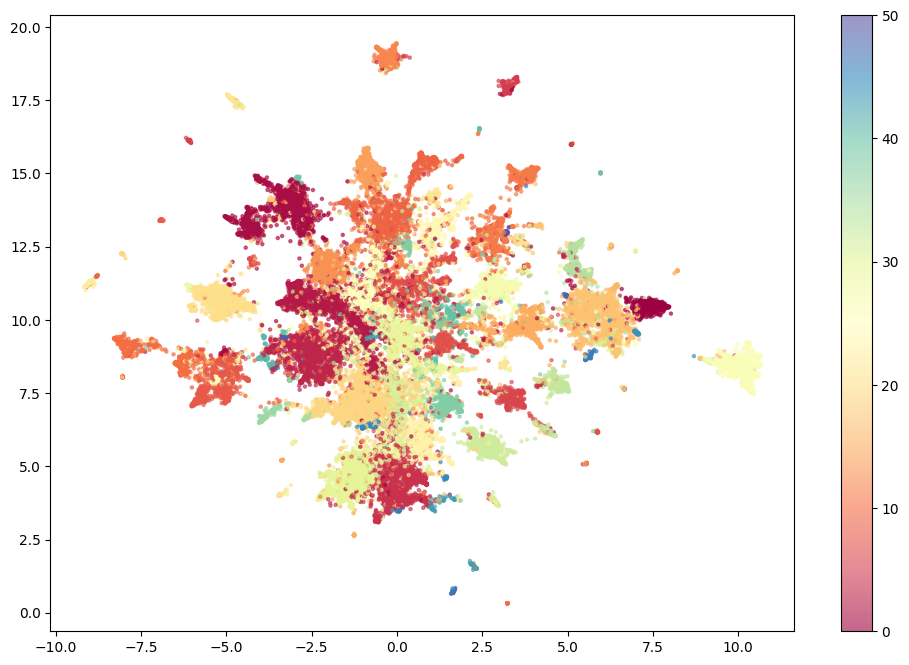

In [147]:
# 5. 可视化结果 (使用PCA的前两个主成分)
plt.figure(figsize=(12, 8))
scatter = plt.scatter(matrix_2d[:, 0], matrix_2d[:, 1], 
                     c=cluster_labels, cmap='Spectral', alpha=0.6, s=5)
plt.colorbar(scatter)
# plt.xlabel('PC1 (解释方差: {:.1f}%)'.format(pca.explained_variance_ratio_[0]*100))
# plt.ylabel('PC2 (解释方差: {:.1f}%)'.format(pca.explained_variance_ratio_[1]*100))
# plt.title(f'Louvain Clustering (PCA50+KNN, k={n_neighbors}, {n_clusters} communities)')
# plt.show()

## split dataset in clusters

In [159]:
cluster_labels.shape

(47626,)

In [160]:
len(keys)

47626

In [161]:
numeric_keys = [int(x) for x in keys]

In [162]:
def split_data_by_patient_id_with_clusters(
    data_df, 
    patient_id_col='node1',
    patient_id=None,
    cluster_labels=None, 
    ratios=[1, 2, 7], 
    random_seed=42
):
    """
    根据病人ID和聚类标签将数据框按指定比例划分为多个子集，
    确保每个聚类内部按比例划分，且各子集间病人ID无重叠
    
    参数:
    data_df: pandas.DataFrame - 输入的数据框
    patient_id_col: str - 病人ID所在的列名，默认为'node1'
    cluster_labels: array-like - 病人的聚类标签，默认为None
    ratios: list - 划分比例，默认为[1, 2, 7] (对应test:val:train)
    random_seed: int - 随机数种子，确保结果可重现
    
    返回:
    tuple - 划分后的多个数据框 (test_df, val_df, train_df)
    """
    
    # 设置随机种子
    np.random.seed(random_seed)
    
    # 确保聚类标签存在
    if cluster_labels is None:
        raise ValueError("必须提供cluster_labels参数")
    
    if patient_id is None:
        raise ValueError("必须提供patient_id参数")
    
    # 为每个患者分配聚类标签
    patient_clusters = pd.DataFrame({
        'patient_id': patient_id,
        'cluster': cluster_labels
    })
    
    # 初始化各集合的患者ID列表
    test_patients = []
    val_patients = []
    train_patients = []
    
    # 对每个聚类进行划分
    for cluster_id in patient_clusters['cluster'].unique():
        # 获取当前聚类的患者ID
        cluster_patients = patient_clusters[
            patient_clusters['cluster'] == cluster_id
        ]['patient_id'].values
        
        # 计算各部分应占的患者数量
        total_patients = len(cluster_patients)
        ratio_sum = sum(ratios)
        
        # 按比例计算各集合的患者数量
        test_size = round(total_patients * ratios[0] / ratio_sum)
        val_size = round(total_patients * ratios[1] / ratio_sum)
        train_size = total_patients - test_size - val_size
        
        # 随机打乱患者ID
        shuffled_ids = np.random.permutation(cluster_patients)
        
        # 划分患者ID
        test_ids = shuffled_ids[:test_size]
        val_ids = shuffled_ids[test_size:test_size+val_size]
        train_ids = shuffled_ids[test_size+val_size:]
        
        # 添加到总体集合
        test_patients.extend(test_ids)
        val_patients.extend(val_ids)
        train_patients.extend(train_ids)
    
    # 根据患者ID划分数据
    test_df = data_df[data_df[patient_id_col].isin(test_patients)]
    val_df = data_df[data_df[patient_id_col].isin(val_patients)]
    train_df = data_df[data_df[patient_id_col].isin(train_patients)]
    
    return test_df, val_df, train_df

In [163]:
test_data, val_data, train_data = split_data_by_patient_id_with_clusters(
    data_df=merged_df_long, 
    patient_id_col='node1',
    patient_id=numeric_keys,
    cluster_labels=cluster_labels, 
    ratios=[1, 2, 7], 
    random_seed=42
)

In [164]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(11045004, 3)
(3160710, 3)
(1583659, 3)


In [165]:
merged_df_long.shape

(15789373, 3)

In [22]:
11045004+3160710+1583659

15789373

In [167]:
train_data.to_csv('/home/llma/wzy/comorbidity/Data/train_data_splitClusters.txt', sep='\t', na_rep='nan', index=False)
val_data.to_csv('/home/llma/wzy/comorbidity/Data/val_data_splitClusters.txt', sep='\t', na_rep='nan', index=False)
test_data.to_csv('/home/llma/wzy/comorbidity/Data/test_data_splitClusters.txt', sep='\t', na_rep='nan', index=False)

In [8]:
prepareInputData(adj_path='/home/llma/wzy/comorbidity/Data/train_data_splitClusters.txt',
                 graph_path_save='/home/llma/wzy/comorbidity/Data/train_graph_splitClusters.pkl',
                 protein_embeddings_path='/home/llma/wzy/comorbidity/Data/gpt_protein_embeddings_dict.pkl',
                 gpt_embeddings_path='/home/llma/wzy/comorbidity/Data/gpt_embeddings_dict.pkl',
                 metabolite_embeddings_path='/home/llma/wzy/comorbidity/Data/metabolite_embeddings_dict.pkl',
                 icd10_embeddings_path='/home/llma/wzy/comorbidity/Data/icd10_embeddings_dict.pkl',
                 UKB_node_feature_save='/home/llma/wzy/comorbidity/Data/UKB_node_feature_gpt_train_splitClusters.npy'
                     )

矩阵形状: (44466, 1536)


In [9]:
prepareInputData(adj_path='/home/llma/wzy/comorbidity/Data/val_data_splitClusters.txt',
                 graph_path_save='/home/llma/wzy/comorbidity/Data/val_graph_splitClusters.pkl',
                 protein_embeddings_path='/home/llma/wzy/comorbidity/Data/gpt_protein_embeddings_dict.pkl',
                 gpt_embeddings_path='/home/llma/wzy/comorbidity/Data/gpt_embeddings_dict.pkl',
                 metabolite_embeddings_path='/home/llma/wzy/comorbidity/Data/metabolite_embeddings_dict.pkl',
                 icd10_embeddings_path='/home/llma/wzy/comorbidity/Data/icd10_embeddings_dict.pkl',
                 UKB_node_feature_save='/home/llma/wzy/comorbidity/Data/UKB_node_feature_gpt_val_splitClusters.npy'
                     )

矩阵形状: (18530, 1536)


In [10]:
prepareInputData(adj_path='/home/llma/wzy/comorbidity/Data/test_data_splitClusters.txt',
                 graph_path_save='/home/llma/wzy/comorbidity/Data/test_graph_splitClusters.pkl',
                 protein_embeddings_path='/home/llma/wzy/comorbidity/Data/gpt_protein_embeddings_dict.pkl',
                 gpt_embeddings_path='/home/llma/wzy/comorbidity/Data/gpt_embeddings_dict.pkl',
                 metabolite_embeddings_path='/home/llma/wzy/comorbidity/Data/metabolite_embeddings_dict.pkl',
                 icd10_embeddings_path='/home/llma/wzy/comorbidity/Data/icd10_embeddings_dict.pkl',
                 UKB_node_feature_save='/home/llma/wzy/comorbidity/Data/UKB_node_feature_gpt_test_splitClusters.npy'
                     )

矩阵形状: (12644, 1536)
